In [1]:
import os
import pandas as pd
import numpy as np
from numpy.linalg import inv

%matplotlib inline    
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cars = pd.read_csv('auto-mpg.data.txt', sep = "\s+", header= None, 
                   names = ["mpg", "cylinders", "displacement", "horsepower", "weight", 
                            "acceleration", "model_year", "origin", "car_name"])
# convert the "?" to Nan
cars["horsepower"] = pd.to_numeric(cars["horsepower"], errors='coerce')
# drop the Nan
cars = cars.dropna().reset_index(drop = True)

In [3]:
cars.shape

(392, 9)

In [4]:
mpg_levels = np.array_split(np.sort(cars.iloc[:,0].values),3)
print("The span of low mpg is", mpg_levels[0][0], ":", (mpg_levels[0][-1]+mpg_levels[1][0])/2)
print("The span of medium mpg is", (mpg_levels[0][-1]+mpg_levels[1][0])/2, ":", mpg_levels[1][-1])
print("The span of high mpg is", mpg_levels[2][0], ":", mpg_levels[2][-1])

The span of low mpg is 9.0 : 18.8
The span of medium mpg is 18.8 : 27.0
The span of high mpg is 27.0 : 46.6


In [5]:
cars['mpg_level'] = np.where(cars.mpg<=18.6, "low",
                           np.where(cars.mpg < 27.0,"medium", "high"))

In [6]:
cars.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
mpg_level        object
dtype: object

In [7]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,mpg_level
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,low
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,low
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,low
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,low
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,low


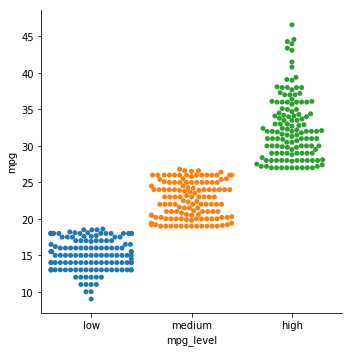

In [8]:
#jitter=False
sns.catplot(x = "mpg_level", y="mpg", kind="swarm", data=cars)

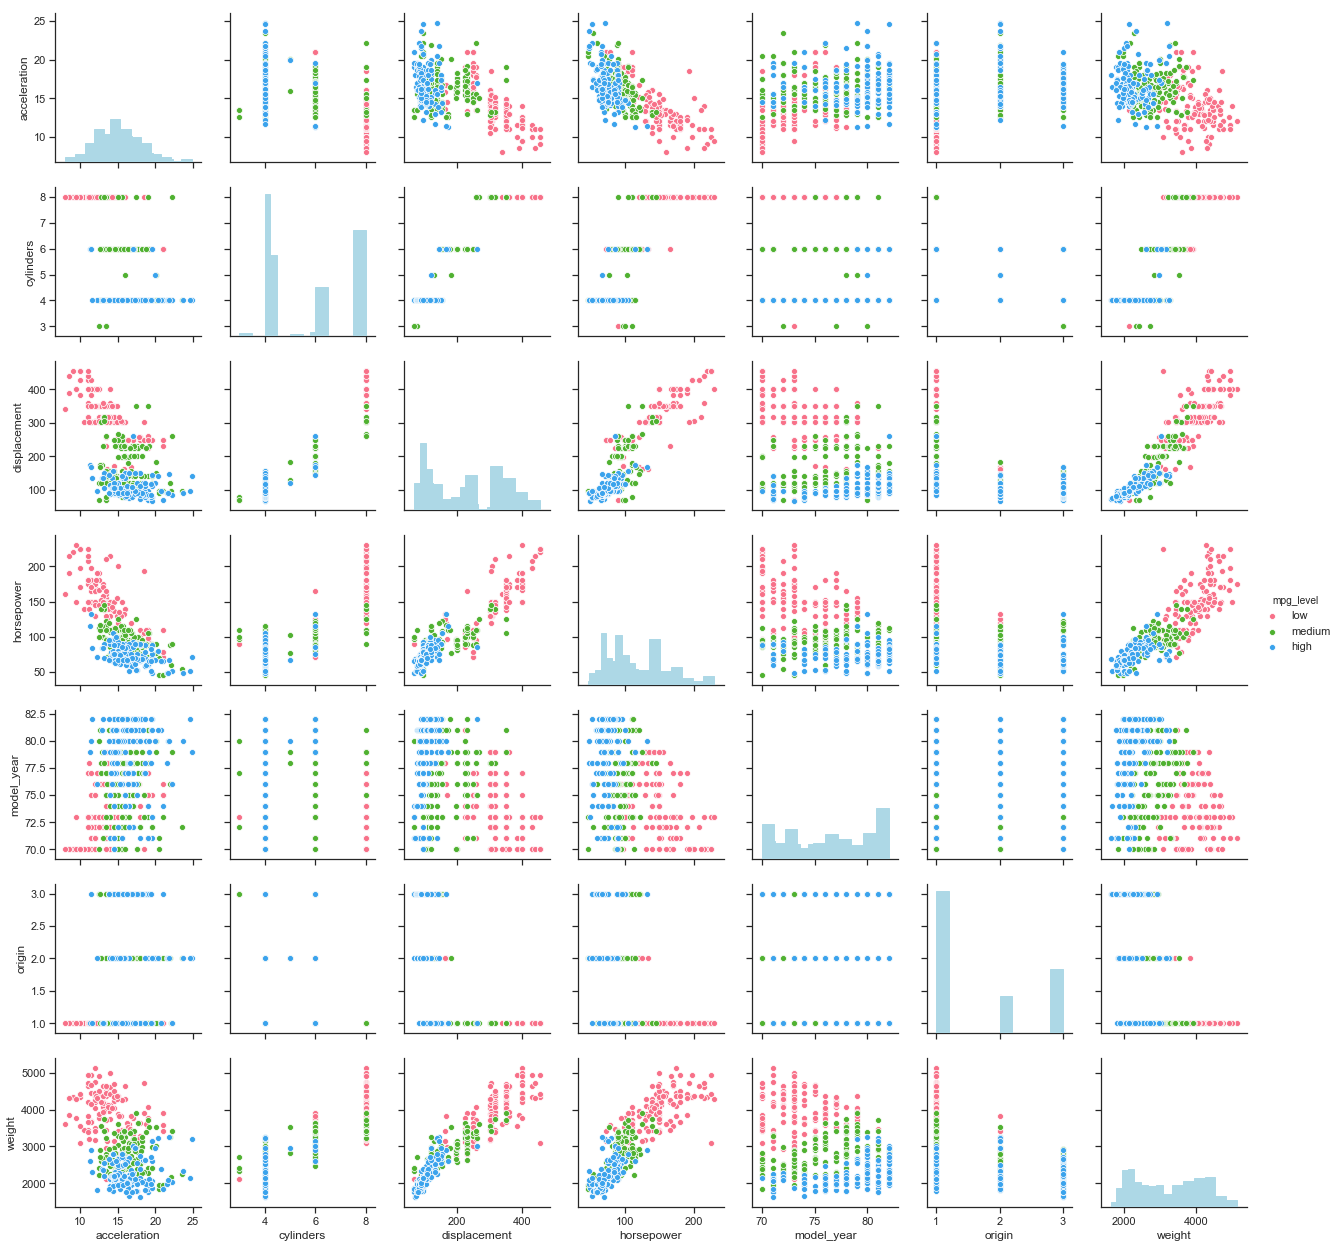

In [9]:
## Q2
sns.set(style="ticks")

sns.pairplot(cars[cars.columns.difference(["mpg","car_name"])],
             hue="mpg_level", palette="husl", diag_kind = "hist",
             diag_kws = {"color": 'lightblue', 'edgecolor':'lightblue',"linewidth":1})

#palette="husl",palette="Set2", color = 'darkred'

In [10]:
## Q3
class LinearRegression:
    """
    : A regression object that uses OLS to fit and predict
    : Init: assign the order
    : fit: precompute the beta
    : predict: Return y hat for X_test
    : change: change the order
    """
    def __init__(self, order):
        """
        Store the order
        """
        self.order = order
    
    def fit(self,x,y):
        self.x1 = np.array([x]).T
        self.y = np.array([y]).T
        #
        # get X matrix
        self.X = self.x1 ** 0
        if self.order != 0:
            for i in range(1, self.order+1):
                self.X = np.append(self.X, self.x1 ** i,axis = 1)
        #
        # get beta vector
        self.beta = np.matmul(np.matmul(inv(np.matmul(self.X.T,self.X)), self.X.T),self.y)
        #
        # get y_hat
        y_hat = np.matmul(self.X, self.beta)[:,0]
        return y_hat
    
    def predict(self,x_test):
        self.x1_test = np.array([x_test]).T
        #
        # get X_test matrix
        self.X_test = self.x1_test ** 0
        if self.order != 0:
            for i in range(1, self.order+1):
                self.X_test = np.append(self.X_test, self.x1_test ** i,axis = 1)
        # get y_predict
        y_predict = np.matmul(self.X_test, self.beta)[:,0]
        return y_predict
        
    def change_order(self,order):
        """
        : After changing the order, the new regressor object should fit in the new order
        """
        self.order = order
        print("The order changes to be "+ self.order+". Please remember to refit the model.")

In [11]:
## Q4
"""
Training and Test set split
Split the data into training set(200/392) and testing set(192/392)
"""
from sklearn.model_selection import train_test_split

train, test = train_test_split(cars, test_size = 192/392, random_state = 1)

## get the train and test data set
X_tr = train[train.columns.difference(['mpg','car_name','mpg_level'])]
y_tr = train.loc[:, 'mpg']
y_tr_log = train.loc[:, 'mpg_level']

X_te = test[test.columns.difference(['mpg','car_name','mpg_level'])]
y_te = test.loc[:, 'mpg']
y_te_log = test.loc[:, 'mpg_level']

In [15]:
def fit_predict(name):
    MSE_tr = []
    MSE_te = [name]
    df_pred = pd.DataFrame({name:X_te[name], 'y': y_te}).reset_index(drop = True)
    df_pred["order"]="test data"
    for order in range(4):
        OLS = LinearRegression(order)
        y_hat = OLS.fit(X_tr[name],y_tr)
        y_pred = OLS.predict(X_te[name])
        mse_tr = np.average((y_tr.values-y_hat)**2)
        mse_te = np.average((y_te.values-y_pred)**2)
        MSE_tr.append(mse_tr)
        MSE_te.append(mse_te)
        df_temp = pd.DataFrame({name:X_te[name], 'y': y_pred}).reset_index(drop = True)
        df_temp["order"] = "order: "+str(order)
        df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    
    return MSE_tr, MSE_te, df_pred

/Users/dandipeng/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


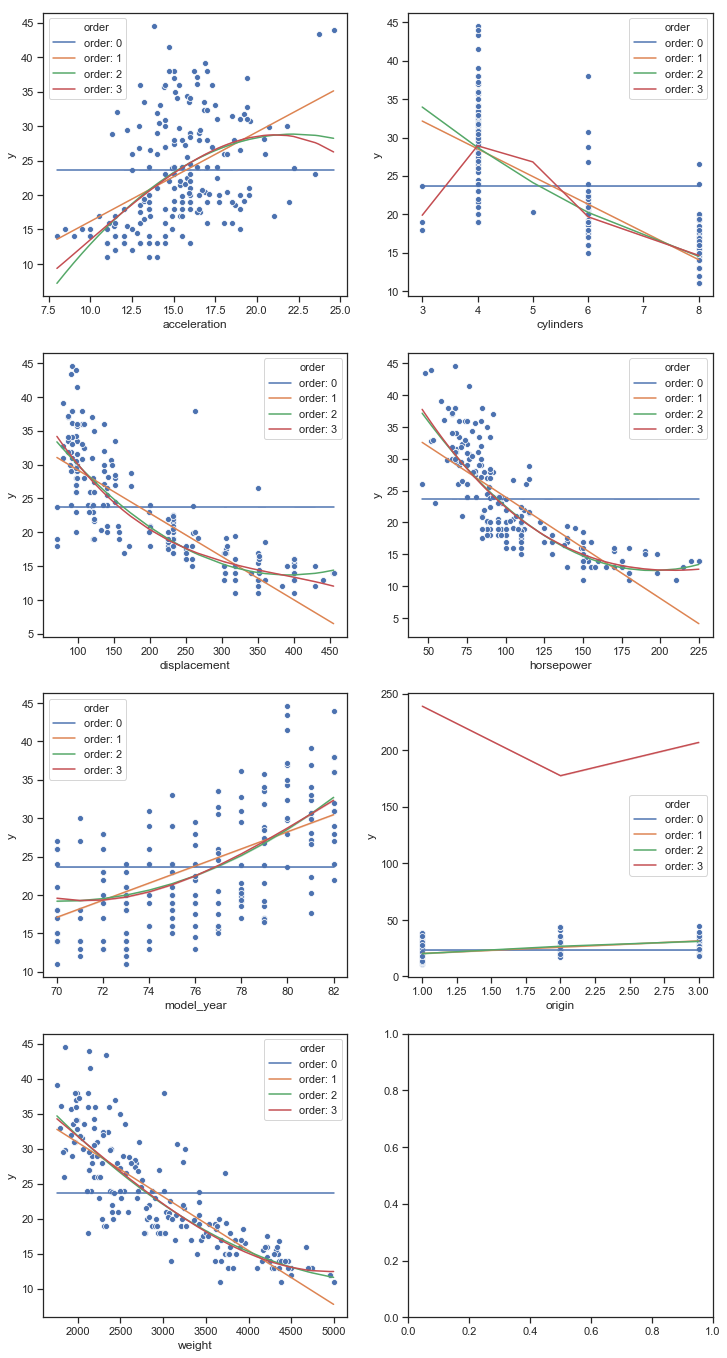

In [16]:
f, ax = plt.subplots(4,2,figsize=(12,24))
mse_tr = []
mse_te = []
position =[]
# get a list of ax indexes
for i in range(0,4):
    for j in range(0,2):
        position.append(i)
        position.append(j)
        

for i in range(0,len(X_tr.columns)):
    mse_tr_temp, mse_te_temp, df_pred = fit_predict(X_tr.columns[i])
    mse_tr.append(mse_tr_temp)
    mse_te.append(mse_te_temp)
    sns.scatterplot(x=X_tr.columns[i], y="y",
                    data=df_pred[df_pred.order == "test data"], 
                    ax=ax[position[2*i],position[2*i+1]])
    sns.lineplot(x=X_tr.columns[i], y="y", hue="order",
                    data=df_pred[df_pred.order != "test data"], 
                 ax=ax[position[2*i],position[2*i+1]])

In [17]:
# MSE for training data
df_mse_tr = pd.DataFrame(mse_tr)
df_mse_tr = df_mse_tr.transpose()
df_mse_tr.columns = df_mse_tr.iloc[0]
df_mse_tr = df_mse_tr[1:].reset_index(drop = True)
df_mse_tr.head()

,59.23109375,59.23109375,59.23109375,59.23109375,59.23109375,59.23109375,59.23109375
0,47.767281,22.558996,18.695822,23.701093,42.720590,39.146664,16.895644
1,46.594413,22.255658,16.198227,19.612571,41.370867,38.995859,15.749647
2,46.526895,21.095576,16.034286,19.574936,41.326501,39795.396850,15.707581


In [43]:
# MSE for test data
df_mse_te = pd.DataFrame(mse_te)
df_mse_te = df_mse_te.transpose()
df_mse_te.columns = df_mse_te.iloc[0]
df_mse_te = df_mse_te[1:].reset_index(drop = True)
df_mse_te.head()

,acceleration,cylinders,displacement,horsepower,model_year,origin,weight
0,62.463,62.463,62.463,62.463,62.463,62.463,62.463
1,52.237,25.6717,24.6945,24.257,38.3142,43.6875,20.5538
2,52.0504,25.72,21.9595,18.5329,35.9311,42.7911,18.9845
3,52.5353,22.7708,22.1241,18.5004,35.8364,40631.4,19.0953


In [44]:
## Q5
class LinearRegression_X:
    """
    : A regression object that uses OLS to fit and predict
    : Init: assign the order
    : fit: precompute the beta
    : predict: Return y hat for X_test
    : change: change the order
    """
    def __init__(self, order):
        """
        Store the order
        """
        self.order = order
    
    def fit(self,X,y):
        self.y = y
        #
        # get X matrix
        self.X = np.ones(shape = (X.shape[0],1))
        if self.order !=0:
            for i in range(1, self.order + 1):
                self.X = np.append(self.X, X ** i,axis = 1)
        #
        # get beta vector
        self.beta = np.matmul(np.matmul(inv(np.matmul(self.X.T,self.X)), self.X.T),self.y)
        #
        # get y_hat
        y_hat = np.matmul(self.X, self.beta)
        return y_hat
    
    def predict(self, X_test):
        # get X matrix
        self.X_test = np.ones(shape = (X_test.shape[0],1))
        if self.order !=0:
            for i in range(1, self.order + 1):
                self.X_test = np.append(self.X_test, X_test ** i,axis = 1)
        # get y_predict
        y_predict = np.matmul(self.X_test, self.beta)
        return y_predict
        
    def change_order(self,order):
        """
        : After changing the order, the new regressor object should fit in the new order
        """
        self.order = order
        print("The order changes to be "+ self.order + ". Please remember to refit the model.")

In [45]:
MSE_tr_X = []
MSE_te_X = []
for i in range(3):
    OLS_X = LinearRegression_X(i)
    y_hat = OLS_X.fit(X_tr.values,y_tr.values)
    y_pred = OLS_X.predict(X_te.values)
    mse_tr_X = np.average((y_tr.values-y_hat)**2)
    mse_te_X = np.average((y_te.values-y_pred)**2)
    MSE_tr_X.append(mse_tr_X)
    MSE_te_X.append(mse_te_X)

In [46]:
pd.DataFrame({'MSE_train':MSE_tr_X, 'MSE_test':MSE_te_X})

,MSE_test,MSE_train
0,62.463019,59.231094
1,12.179245,10.310112
2,8.398520,6.784805


In [47]:
## Q6
from sklearn.linear_model import LogisticRegression
Logreg = LogisticRegression()
Logreg.fit(X_tr.values,y_tr_log.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
y_pred_log = Logreg.predict(X_te.values)

In [49]:
print('Accuracy of logistic regression classifier on training set: {:.10f}'.
      format(Logreg.score(X_tr.values, y_tr_log.values)))
print('Accuracy of logistic regression classifier on test set: {:.10f}'.
      format(Logreg.score(X_te.values, y_te_log.values)))

Accuracy of logistic regression classifier on training set: 0.8450000000
Accuracy of logistic regression classifier on test set: 0.7552083333


In [54]:
## Q7

X_new = np.array([[9,6,350,180,80,1,3700]])
OLS_X = LinearRegression_X(2)
OLS_X.fit(X_tr.values,y_tr.values)
OLS_X.predict(X_new)

array([19.14056406])

In [51]:
Logreg.predict(X_new)

array(['low'], dtype=object)

In [90]:
## Q8
X_ox = np.array([0.576])

In [91]:
OLS_ox = LinearRegression(2)
OLS_ox.fit(X_tr['horsepower'],y_tr)
OLS_ox.predict(X_ox)

array([54.46038254])